# ⚙️ Setup

In [1]:
from __future__ import annotations
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 📊 Analysis

In [2]:
try:
    df = pd.read_csv("evaluations/retriever_evaluation.csv")
except Exception as e:
    print(e)

In [3]:
# df.columns

In [4]:
from typing import Optional, Union

In [5]:
def _safe_to_datetime(df: pd.DataFrame, col: str = "timestamp") -> pd.DataFrame:
    if col in df.columns and not np.issubdtype(df[col].dtype, np.datetime64):
        df = df.copy()
        df[col] = pd.to_datetime(df[col], errors="coerce", utc=False)
    return df

def _ensure_numeric(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    """
    Light cleanup:
    - coerce numeric knobs to numeric
    - coerce timestamp to datetime
    - drop exact duplicate rows
    """
    num_cols = ["ef_construction","bm25_b","bm25_k1","alpha","top_k",
                "Mean Precision@3","Mean Recall@3","Mean F1@3",
                "Mean Precision@5","Mean Recall@5","Mean F1@5",
                "Mean Precision@10","Mean Recall@10","Mean F1@10",
                "no_of_questions"]
    df = _ensure_numeric(df, [c for c in num_cols if c in df.columns])
    df = _safe_to_datetime(df, "timestamp")
    return df.drop_duplicates().reset_index(drop=True)

In [6]:
df = preprocess(df)

In [7]:
_METRIC_BASES = {
    "precision": "Precision",
    "recall": "Recall",
    "f1": "F1",
    "ndcg": "nDCG",
}


def metric_col(metric: str = "f1", k: int = 5) -> str:
    """
    Map (metric, k) -> column name in your schema.
    Example: metric_col("f1", 10) -> "Mean F1@10"
    """
    m = metric.strip().lower()
    if m not in _METRIC_BASES:
        raise ValueError(f"metric must be one of {list(_METRIC_BASES)}")
    return f"Mean {_METRIC_BASES[m]}@{int(k)}"


def leaderboard(
    df: pd.DataFrame,
    by: tuple[str] = (
        "embeddings",
        "reranker",
        "chunking_strategy",
        "docs_cleaning_strategy",
        "query_cleaning_strategy",
        "window_size",
        "overlap_size",
        "pdf_num_split",
        "chunk_overlap_rate",
        "top_k",
        "alpha",
    ),
    metric: str = "f1",
    k: int = 5,
    n: int = 20,
    with_error: bool = True,
) -> pd.DataFrame:
    """
    Aggregated leaderboard (mean ± sem if with_error=True), sorted descending by metric@k.
    """
    col = metric_col(metric, k)
    use_cols = [c for c in by if c in df.columns]
    if not use_cols:
        raise ValueError("No valid grouping columns found.")
    g = df.groupby(use_cols, dropna=False)[col]
    agg = g.agg(["mean", "count", "std"]).reset_index()
    agg.rename(columns={"mean": col}, inplace=True)

    if with_error:
        agg["sem"] = agg["std"] / np.sqrt(agg["count"]).replace(0, np.nan)

    out_cols = use_cols + [col, "count"]
    if with_error:
        out_cols += ["sem"]
    return agg.sort_values(col, ascending=False).reset_index().head(n)[out_cols]

In [8]:
lb = leaderboard(
    df,
    by=(
        "embeddings",
        "reranker",
        "chunking_strategy",
        "docs_cleaning_strategy",
        "query_cleaning_strategy",
        "window_size",
        "overlap_size",
        "pdf_num_split",
        "chunk_overlap_rate",
        "top_k",
        "alpha",
        "ef_construction",
        "bm25_b",
        "bm25_k1",
    ),
    metric="precision",
    k=5,
    n=20,
)
lb

,embeddings,reranker,chunking_strategy,docs_cleaning_strategy,query_cleaning_strategy,window_size,overlap_size,pdf_num_split,chunk_overlap_rate,top_k,alpha,ef_construction,bm25_b,bm25_k1,Mean Precision@5,count,sem
0,intfloat/multilingual-e5-base,NaN,section_based_chunking,NaN,NaN,NaN,NaN,NaN,NaN,10,0.7,500,0.7,1.25,1.00,1,NaN
1,intfloat/multilingual-e5-base,NaN,fixed_window_chunking,cleaning_strategy_v1,NaN,100.0,50.0,NaN,NaN,10,0.7,300,0.7,1.25,1.00,1,NaN
2,intfloat/multilingual-e5-base,NaN,fixed_window_chunking,docs_cleaning_strategy_v2,query_cleaning_strategy_v1,100.0,50.0,NaN,NaN,10,0.8,300,0.7,1.25,0.96,1,NaN
3,intfloat/multilingual-e5-base,NaN,section_based_chunking,cleaning_strategy_v2,NaN,NaN,NaN,NaN,NaN,10,0.7,500,0.7,1.25,0.96,1,NaN
4,intfloat/multilingual-e5-base,NaN,section_based_chunking,NaN,NaN,NaN,NaN,NaN,NaN,10,0.0,300,0.7,1.25,0.94,2,0.02
5,intfloat/multilingual-e5-base,NaN,fixed_window_chunking,cleaning_strategy_v1,NaN,150.0,0.0,NaN,NaN,10,0.7,300,0.7,1.25,0.92,1,NaN
6,intfloat/multilingual-e5-base,NaN,section_based_chunking,NaN,NaN,NaN,NaN,NaN,NaN,10,0.8,300,0.7,1.25,0.92,1,NaN
7,intfloat/multilingual-e5-base,NaN,fixed_window_chunking,cleaning_strategy_v2,NaN,100.0,50.0,NaN,NaN,10,0.8,300,0.7,1.25,0.92,1,NaN
8,intfloat/multilingual-e5-base,NaN,section_based_chunking,NaN,NaN,NaN,NaN,NaN,NaN,10,0.5,300,0.7,1.25,0.92,1,NaN
9,intfloat/multilingual-e5-base,NaN,section_based_chunking,NaN,NaN,NaN,NaN,NaN,NaN,10,0.2,300,0.7,1.25,0.92,1,NaN


In [9]:
lb = leaderboard(
    df,
    by=(
        "embeddings",
        "reranker",
        "chunking_strategy",
        "docs_cleaning_strategy",
        "query_cleaning_strategy",
        "window_size",
        "overlap_size",
        "pdf_num_split",
        "chunk_overlap_rate",
        "top_k",
        "alpha",
        "ef_construction",
        "bm25_b",
        "bm25_k1",
    ),
    metric="recall",
    k=5,
    n=20,
)
lb

,embeddings,reranker,chunking_strategy,docs_cleaning_strategy,query_cleaning_strategy,window_size,overlap_size,pdf_num_split,chunk_overlap_rate,top_k,alpha,ef_construction,bm25_b,bm25_k1,Mean Recall@5,count,sem
0,intfloat/multilingual-e5-base,cross-encoder/mmarco-mMiniLMv2-L12-H384-v1,pdf_based_recursively_split_chunking_v2,docs_cleaning_strategy_v2,query_cleaning_strategy_v1,NaN,NaN,NaN,0.2,10,0.8,300,0.7,1.25,0.725000,1,NaN
1,intfloat/multilingual-e5-base,NaN,pdf_based_recursively_split_chunking,docs_cleaning_strategy_v2,query_cleaning_strategy_v1,NaN,100.0,3.0,NaN,10,0.8,300,0.7,1.25,0.715952,2,0.118333
2,intfloat/multilingual-e5-base,NaN,recursively_split_chunking,docs_cleaning_strategy_v2,query_cleaning_strategy_v1,300.0,50.0,NaN,NaN,10,0.8,300,0.7,1.25,0.712500,1,NaN
3,intfloat/multilingual-e5-base,NaN,recursively_split_chunking,docs_cleaning_strategy_v2,query_cleaning_strategy_v1,1200.0,200.0,NaN,NaN,10,0.8,300,0.7,1.25,0.675357,2,0.090357
4,intfloat/multilingual-e5-base,NaN,pdf_based_chunking,docs_cleaning_strategy_v2,query_cleaning_strategy_v1,NaN,NaN,NaN,NaN,10,0.8,300,0.7,1.25,0.628611,4,0.064441
5,intfloat/multilingual-e5-base,NaN,fixed_window_chunking,cleaning_strategy_v2,NaN,100.0,50.0,NaN,NaN,10,0.7,300,0.7,1.25,0.620486,2,0.098264
6,intfloat/multilingual-e5-base,NaN,recursively_split_chunking,docs_cleaning_strategy_v2,query_cleaning_strategy_v1,600.0,100.0,NaN,NaN,10,0.8,300,0.7,1.25,0.586190,2,0.011587
7,intfloat/multilingual-e5-base,NaN,section_based_chunking,NaN,NaN,NaN,NaN,NaN,NaN,10,0.2,300,0.7,1.25,0.540079,1,NaN
8,intfloat/multilingual-e5-base,NaN,recursively_split_chunking,docs_cleaning_strategy_v2,query_cleaning_strategy_v1,100.0,50.0,NaN,NaN,10,0.8,300,0.7,1.25,0.538472,2,0.017639
9,intfloat/multilingual-e5-base,NaN,fixed_window_chunking,cleaning_strategy_v1,NaN,100.0,50.0,NaN,NaN,10,0.7,300,0.7,1.25,0.536111,1,NaN


In [10]:
lb = leaderboard(
    df,
    by=(
        "embeddings",
        "reranker",
        "chunking_strategy",
        "docs_cleaning_strategy",
        "query_cleaning_strategy",
        "window_size",
        "overlap_size",
        "pdf_num_split",
        "chunk_overlap_rate",
        "top_k",
        "alpha",
        "ef_construction",
        "bm25_b",
        "bm25_k1",
    ),
    metric="f1",
    k=5,
    n=20,
)
lb

,embeddings,reranker,chunking_strategy,docs_cleaning_strategy,query_cleaning_strategy,window_size,overlap_size,pdf_num_split,chunk_overlap_rate,top_k,alpha,ef_construction,bm25_b,bm25_k1,Mean F1@5,count,sem
0,intfloat/multilingual-e5-base,NaN,fixed_window_chunking,cleaning_strategy_v1,NaN,100.0,50.0,NaN,NaN,10,0.7,300,0.7,1.25,0.696703,1,NaN
1,intfloat/multilingual-e5-base,NaN,section_based_chunking,NaN,NaN,NaN,NaN,NaN,NaN,10,0.7,500,0.7,1.25,0.687179,1,NaN
2,intfloat/multilingual-e5-base,NaN,section_based_chunking,NaN,NaN,NaN,NaN,NaN,NaN,10,0.2,300,0.7,1.25,0.678022,1,NaN
3,intfloat/multilingual-e5-base,NaN,section_based_chunking,NaN,NaN,NaN,NaN,NaN,NaN,10,0.5,300,0.7,1.25,0.667399,1,NaN
4,intfloat/multilingual-e5-base,NaN,fixed_window_chunking,docs_cleaning_strategy_v2,query_cleaning_strategy_v1,100.0,50.0,NaN,NaN,10,0.8,300,0.7,1.25,0.665934,1,NaN
5,intfloat/multilingual-e5-base,cross-encoder/mmarco-mMiniLMv2-L12-H384-v1,pdf_based_recursively_split_chunking_v2,docs_cleaning_strategy_v2,query_cleaning_strategy_v1,NaN,NaN,NaN,0.2,10,0.8,300,0.7,1.25,0.664957,1,NaN
6,intfloat/multilingual-e5-base,NaN,section_based_chunking,NaN,NaN,NaN,NaN,NaN,NaN,10,0.0,300,0.7,1.25,0.661905,2,0.014286
7,intfloat/multilingual-e5-base,NaN,section_based_chunking,cleaning_strategy_v2,NaN,NaN,NaN,NaN,NaN,10,0.7,500,0.7,1.25,0.657143,1,NaN
8,intfloat/multilingual-e5-base,NaN,pdf_based_recursively_split_chunking,docs_cleaning_strategy_v2,query_cleaning_strategy_v1,NaN,NaN,5.0,0.2,10,0.8,300,0.7,1.25,0.655678,1,NaN
9,intfloat/multilingual-e5-base,NaN,fixed_window_chunking,cleaning_strategy_v1,NaN,150.0,0.0,NaN,NaN,10,0.7,300,0.7,1.25,0.654212,1,NaN


In [11]:
lb = leaderboard(
    df,
    by=(
        "embeddings",
        "reranker",
        "chunking_strategy",
        "docs_cleaning_strategy",
        "query_cleaning_strategy",
        "window_size",
        "overlap_size",
        "pdf_num_split",
        "chunk_overlap_rate",
        "top_k",
        "alpha",
        "ef_construction",
        "bm25_b",
        "bm25_k1",
    ),
    metric="ndcg",
    k=5,
    n=20,
)
lb

,embeddings,reranker,chunking_strategy,docs_cleaning_strategy,query_cleaning_strategy,window_size,overlap_size,pdf_num_split,chunk_overlap_rate,top_k,alpha,ef_construction,bm25_b,bm25_k1,Mean nDCG@5,count,sem
0,intfloat/multilingual-e5-base,cross-encoder/mmarco-mMiniLMv2-L12-H384-v1,pdf_based_recursively_split_chunking_v2,docs_cleaning_strategy_v2,query_cleaning_strategy_v1,NaN,NaN,NaN,0.2,10,0.8,300,0.7,1.25,1.000000,1,NaN
1,intfloat/multilingual-e5-base,NaN,fixed_window_chunking,cleaning_strategy_v1,NaN,100.0,50.0,NaN,NaN,10,0.7,300,0.7,1.25,1.000000,1,NaN
2,intfloat/multilingual-e5-base,NaN,pdf_based_recursively_split_chunking,docs_cleaning_strategy_v2,query_cleaning_strategy_v1,NaN,NaN,5.0,0.2,10,0.8,300,0.7,1.25,0.939843,1,NaN
3,intfloat/multilingual-e5-base,NaN,fixed_window_chunking,cleaning_strategy_v1,NaN,150.0,0.0,NaN,NaN,10,0.7,300,0.7,1.25,0.936870,1,NaN
4,intfloat/multilingual-e5-base,NaN,fixed_window_chunking,cleaning_strategy_v2,NaN,100.0,50.0,NaN,NaN,10,0.8,300,0.7,1.25,0.936870,1,NaN
5,intfloat/multilingual-e5-base,NaN,fixed_window_chunking,docs_cleaning_strategy_v2,query_cleaning_strategy_v1,100.0,50.0,NaN,NaN,10,0.8,300,0.7,1.25,0.932168,1,NaN
6,intfloat/multilingual-e5-base,NaN,section_based_chunking,cleaning_strategy_v2,NaN,NaN,NaN,NaN,NaN,10,0.7,500,0.7,1.25,0.932168,1,NaN
7,intfloat/multilingual-e5-base,NaN,fixed_window_chunking,cleaning_strategy_v1,NaN,NaN,NaN,NaN,NaN,10,0.7,300,0.7,1.25,0.872011,1,NaN
8,intfloat/multilingual-e5-base,NaN,pdf_based_recursively_split_chunking,docs_cleaning_strategy_v2,query_cleaning_strategy_v1,NaN,100.0,3.0,NaN,10,0.8,300,0.7,1.25,0.853450,2,0.008192
9,intfloat/multilingual-e5-base,NaN,pdf_based_recursively_split_chunking,docs_cleaning_strategy_v2,query_cleaning_strategy_v1,NaN,100.0,5.0,NaN,10,0.8,300,0.7,1.25,0.839825,1,NaN


In [12]:
def _finish(ax, title: str, xlab: str = "", ylab: str = ""):
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.grid(True, linestyle="--", alpha=0.3)

def bar_by_group(
    df: pd.DataFrame, group: str, metric: str = "f1", k: int = 5, min_count: int = 1, rotate_x=0
):
    """
    Bar chart: mean metric@k by a categorical group (e.g., embeddings or reranker).
    """
    col = metric_col(metric, k)
    if group not in df.columns:
        raise ValueError(f"{group} not in DataFrame")
    g = df.groupby(group)[col].agg(["mean","count","std"]).reset_index()
    g = g[g["count"] >= min_count]
    g["sem"] = g["std"] / np.sqrt(g["count"]).replace(0, np.nan)
    
    print(g["sem"])
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(g[group].astype(str), g["mean"], yerr=g["sem"])
    ax.set_xticklabels(g[group].astype(str), rotation=rotate_x, ha="right")
    _finish(ax, f"{col} by {group}", group, col)
    plt.tight_layout()
    plt.show()

0    0.013267
Name: sem, dtype: float64


/var/folders/0r/dktk9n0551j0gkccz4k6246h0000gn/T/ipykernel_8953/2339022941.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(g[group].astype(str), rotation=rotate_x, ha="right")


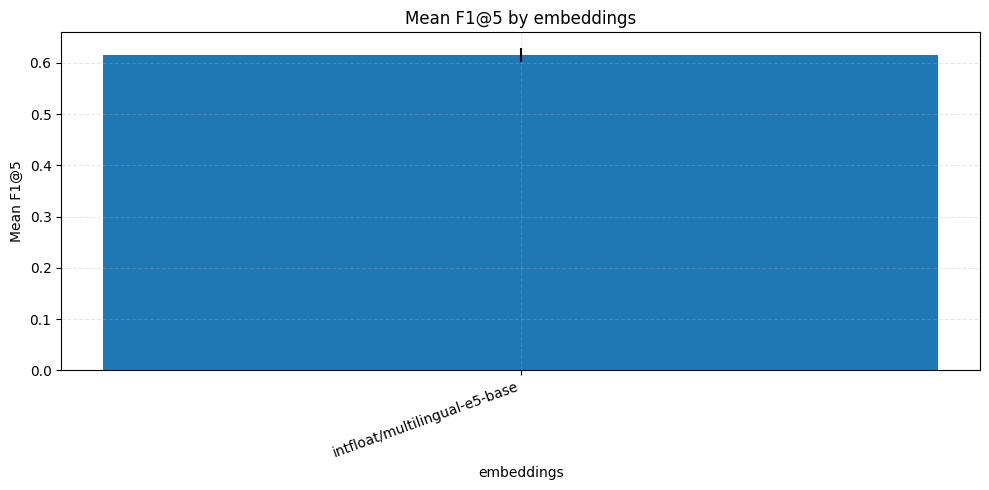

/var/folders/0r/dktk9n0551j0gkccz4k6246h0000gn/T/ipykernel_8953/2339022941.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(g[group].astype(str), rotation=rotate_x, ha="right")


0   NaN
Name: sem, dtype: float64


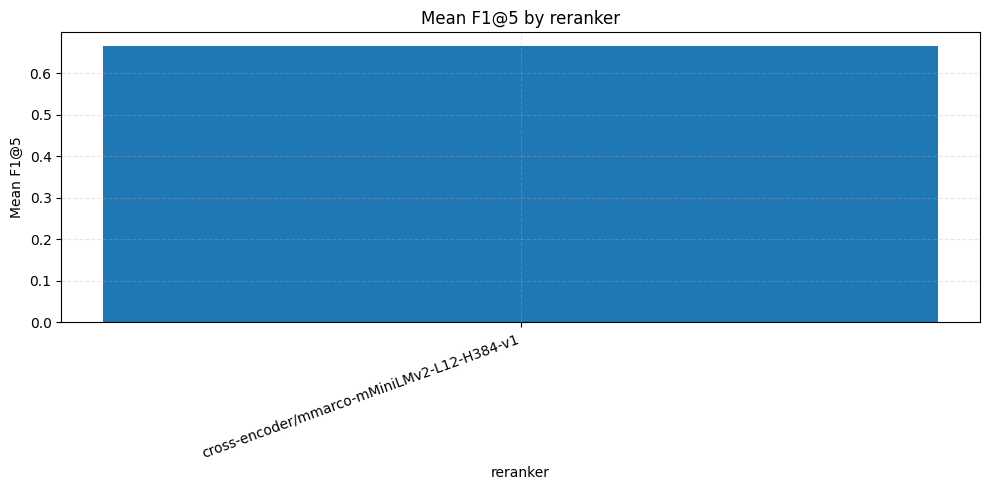

0    0.029889
1    0.064441
2    0.063954
3         NaN
4    0.033586
5    0.008424
Name: sem, dtype: float64


/var/folders/0r/dktk9n0551j0gkccz4k6246h0000gn/T/ipykernel_8953/2339022941.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(g[group].astype(str), rotation=rotate_x, ha="right")


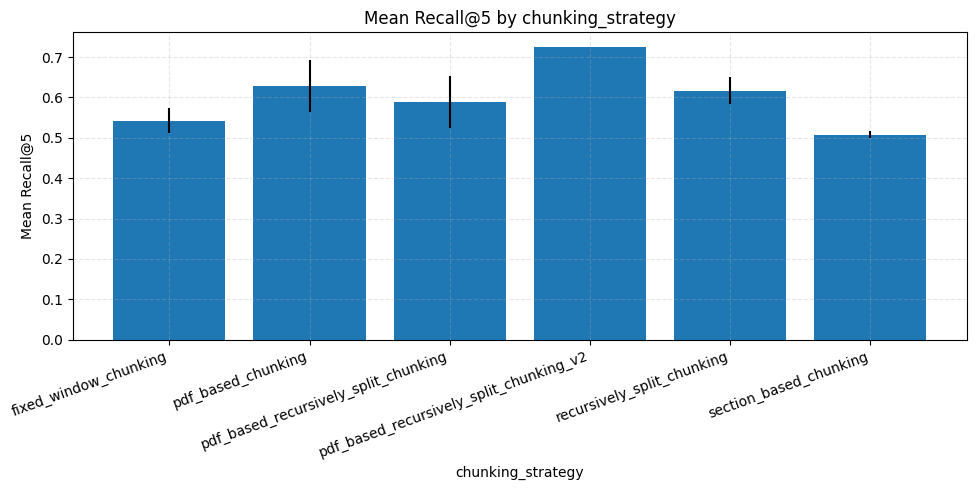

0    0.068730
1    0.156950
2    0.092952
3         NaN
4    0.087598
5    0.023831
Name: sem, dtype: float64


/var/folders/0r/dktk9n0551j0gkccz4k6246h0000gn/T/ipykernel_8953/2339022941.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(g[group].astype(str), rotation=rotate_x, ha="right")


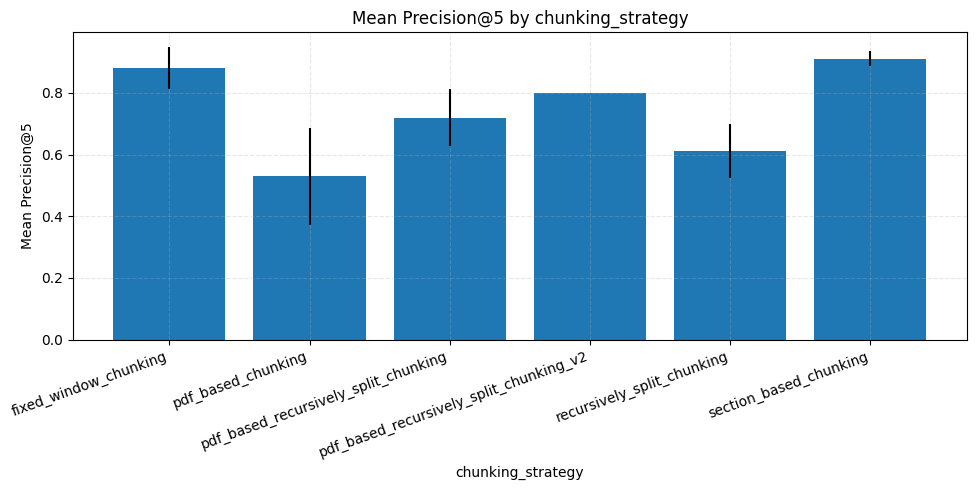

0    0.010994
1    0.058768
2    0.020695
3         NaN
4    0.033583
5    0.012269
Name: sem, dtype: float64


/var/folders/0r/dktk9n0551j0gkccz4k6246h0000gn/T/ipykernel_8953/2339022941.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(g[group].astype(str), rotation=rotate_x, ha="right")


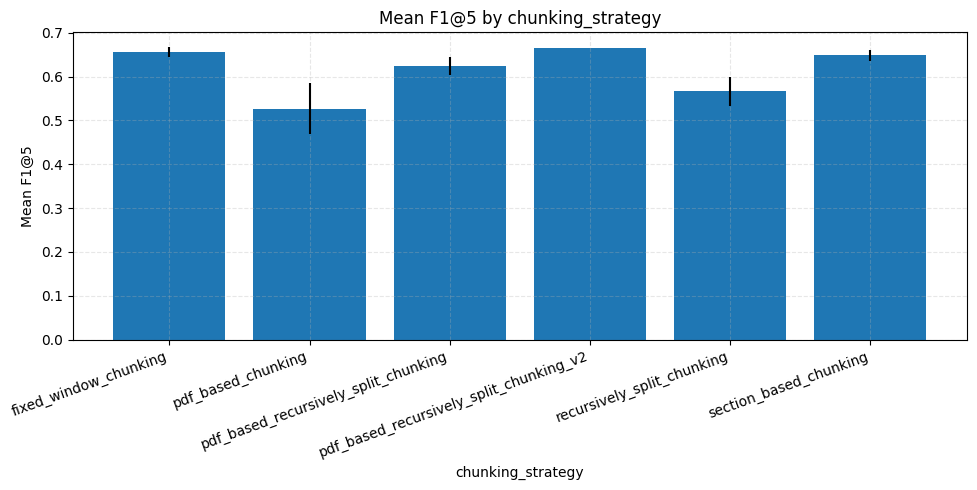

0    0.022466
1    0.015674
2    0.020900
Name: sem, dtype: float64


/var/folders/0r/dktk9n0551j0gkccz4k6246h0000gn/T/ipykernel_8953/2339022941.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(g[group].astype(str), rotation=rotate_x, ha="right")


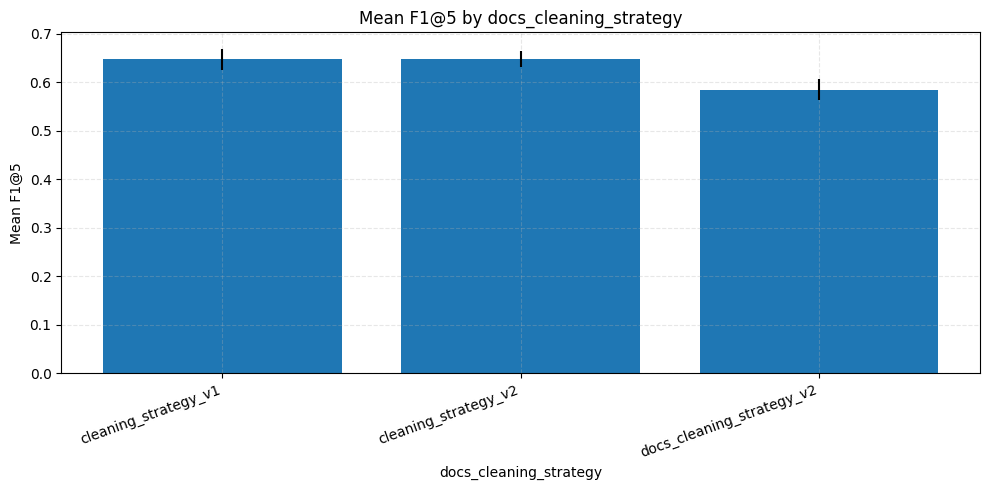

In [13]:
# 3) Group comparisons
bar_by_group(df, group="embeddings", metric="f1", k=5, rotate_x=20)
bar_by_group(df, group="reranker", metric="f1", k=5, rotate_x=20)
bar_by_group(df, group="chunking_strategy", metric="recall", k=5, rotate_x=20)
bar_by_group(df, group="chunking_strategy", metric="precision", k=5, rotate_x=20)
bar_by_group(df, group="chunking_strategy", metric="f1", k=5, rotate_x=20)
bar_by_group(df, group="docs_cleaning_strategy", metric="f1", k=5, rotate_x=20)

In [14]:
def precision_recall_scatter(df: pd.DataFrame, k: int = 5):
    """
    Scatter: Precision@k vs Recall@k with point labels as short config strings.
    """
    pcol = metric_col("precision", k)
    rcol = metric_col("recall", k)
    if pcol not in df.columns or rcol not in df.columns:
        raise ValueError("Missing precision/recall columns")

    # Small label: embeddings|reranker|chunking|clean
    labels = (
        df.get("embeddings", pd.Series(["?"]*len(df))).astype(str).str.slice(0, 14) + "|" +
        df.get("reranker", pd.Series(["?"]*len(df))).astype(str).str.slice(0, 10) + "|" +
        df.get("chunking_strategy", pd.Series(["?"]*len(df))).astype(str).str.slice(0, 10) + "|" +
        df.get("docs_cleaning_strategy", pd.Series(["?"]*len(df))).astype(str).str.slice(0, 6)
    )

    fig, ax = plt.subplots(figsize=(7, 6))
    ax.scatter(df[pcol], df[rcol], alpha=0.8)
    # Optional thin labels (avoid clutter if many points)
    if len(df) <= 40:
        for x, y, lab in zip(df[pcol], df[rcol], labels):
            ax.annotate(lab, (x, y), xytext=(3, 3), textcoords="offset points", fontsize=8)
    # Fit simple trend
    try:
        coeff = np.polyfit(df[pcol], df[rcol], 1)
        xs = np.linspace(df[pcol].min(), df[pcol].max(), 100)
        ys = xs * coeff[0] + coeff[1]
        ax.plot(xs, ys, linewidth=1)
    except Exception:
        pass
    _finish(ax, f"Precision@{k} vs Recall@{k}", f"Precision@{k}", f"Recall@{k}")
    fig.tight_layout()
    plt.show()

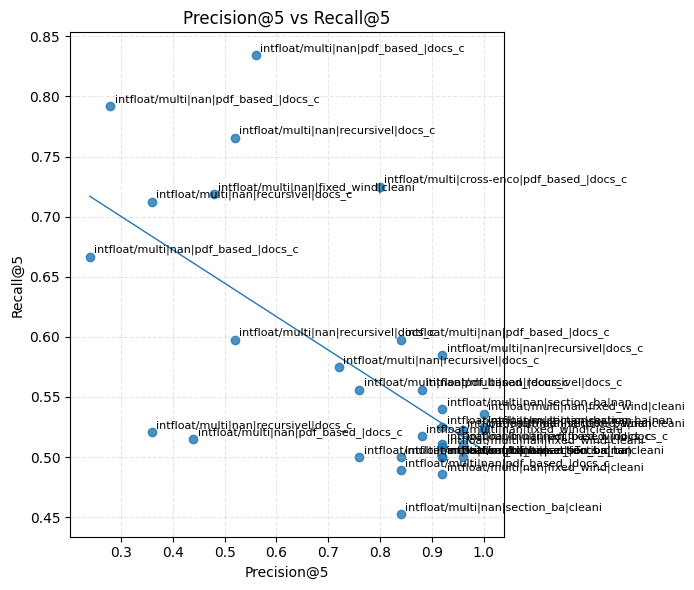

In [15]:
# 4) Trade-off: Precision vs Recall at k=5
precision_recall_scatter(df, k=5)

In [16]:
def metric_vs_numeric(
    df: pd.DataFrame,
    x: str = "top_k",
    by: Optional[str] = "embeddings",
    metric: str = "f1",
    k: int = 5,
    agg: str = "mean",
):
    """
    Line plot: metric@k vs a numeric knob (e.g., top_k, alpha, bm25_k1),
    optionally with multiple lines for 'by' (e.g., embeddings).
    """
    col = metric_col(metric, k)
    if x not in df.columns: raise ValueError(f"{x} not in DataFrame")
    if by and by not in df.columns: by = None

    if by:
        g = df.groupby([by, x])[col].agg(agg).reset_index()
        fig, ax = plt.subplots(figsize=(8, 5))
        for key, chunk in g.groupby(by):
            chunk = chunk.sort_values(x)
            ax.plot(chunk[x], chunk[col], marker="o", label=str(key))
        ax.legend(title=by, frameon=False)
        _finish(ax, f"{col} vs {x} by {by}", x, col)
    else:
        g = df.groupby(x)[col].agg(agg).reset_index().sort_values(x)
        fig, ax = plt.subplots(figsize=(7, 4))
        ax.plot(g[x], g[col], marker="o")
        _finish(ax, f"{col} vs {x}", x, col)
    fig.tight_layout()
    plt.show()

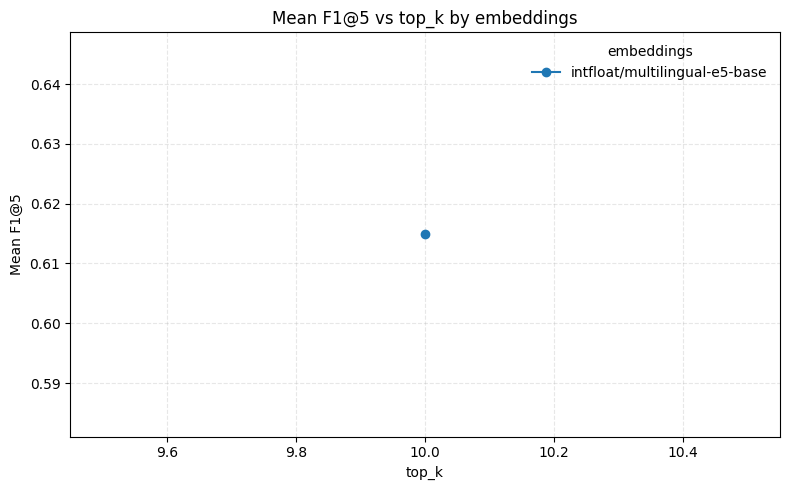

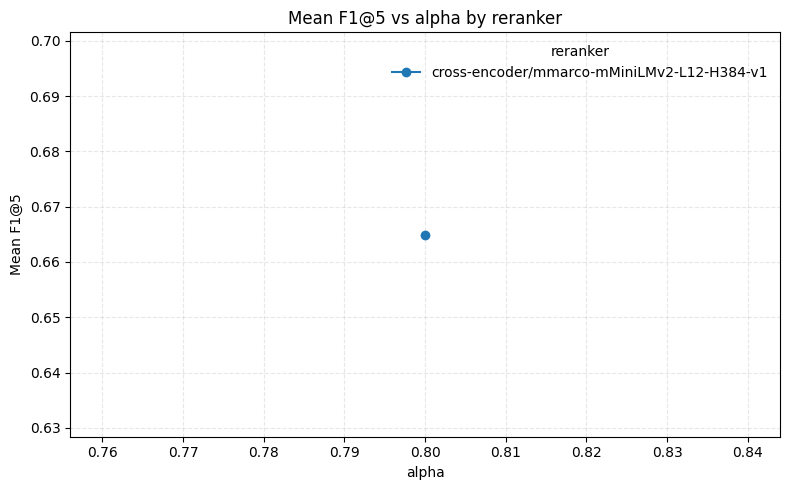

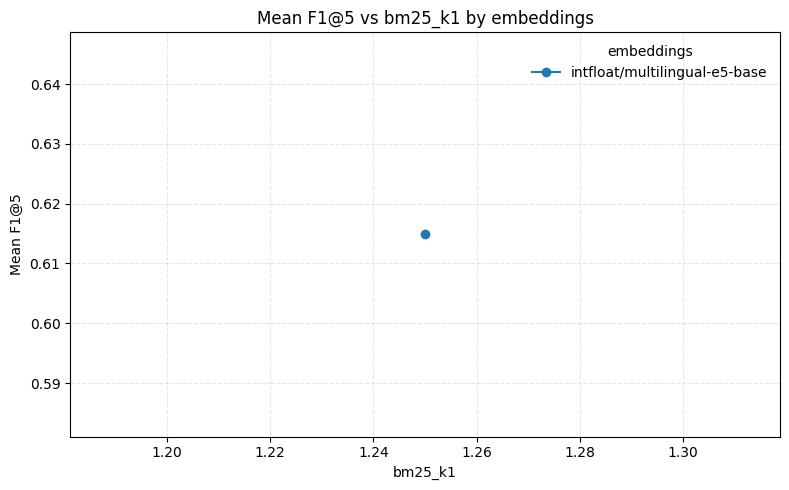

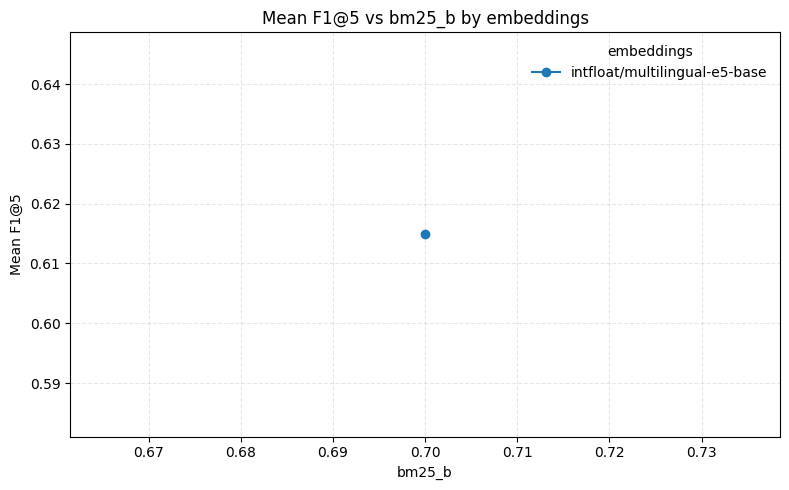

In [17]:
# 5) Sensitivity to knobs
metric_vs_numeric(df, x="top_k", by="embeddings", metric="f1", k=5)
metric_vs_numeric(df, x="alpha", by="reranker", metric="f1", k=5)
metric_vs_numeric(df, x="bm25_k1", by="embeddings", metric="f1", k=5)
metric_vs_numeric(df, x="bm25_b", by="embeddings", metric="f1", k=5)

In [18]:
def two_way_heatmap(
    df: pd.DataFrame, rows: str, cols: str, metric: str = "f1", k: int = 5, agg: str = "mean"
):
    """
    Heatmap: rows x cols -> aggregated metric@k.
    """
    col = metric_col(metric, k)
    for c in (rows, cols):
        if c not in df.columns: raise ValueError(f"{c} not in DataFrame")
    pivot = pd.pivot_table(df, values=col, index=rows, columns=cols, aggfunc=agg)
    fig, ax = plt.subplots(figsize=(1.2*pivot.shape[1]+4, 1.2*pivot.shape[0]+3))
    im = ax.imshow(pivot.values, aspect="auto")
    ax.set_xticks(range(pivot.shape[1]))
    ax.set_xticklabels([str(c) for c in pivot.columns], rotation=45, ha="right")
    ax.set_yticks(range(pivot.shape[0]))
    ax.set_yticklabels([str(r) for r in pivot.index])
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            val = pivot.values[i, j]
            if not (isinstance(val, float) and math.isnan(val)):
                ax.text(j, i, f"{val:.3f}", ha="center", va="center")
    _finish(ax, f"{col} heatmap by {rows} x {cols}", cols, rows)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    plt.show()

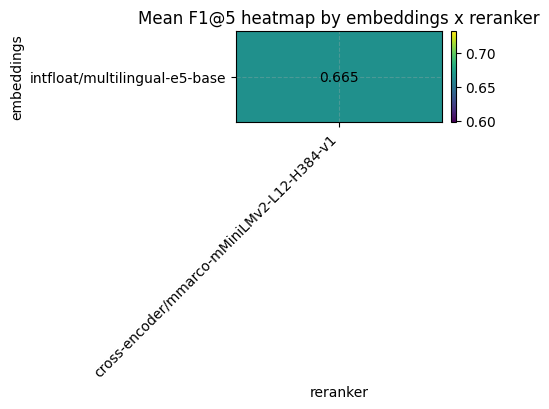

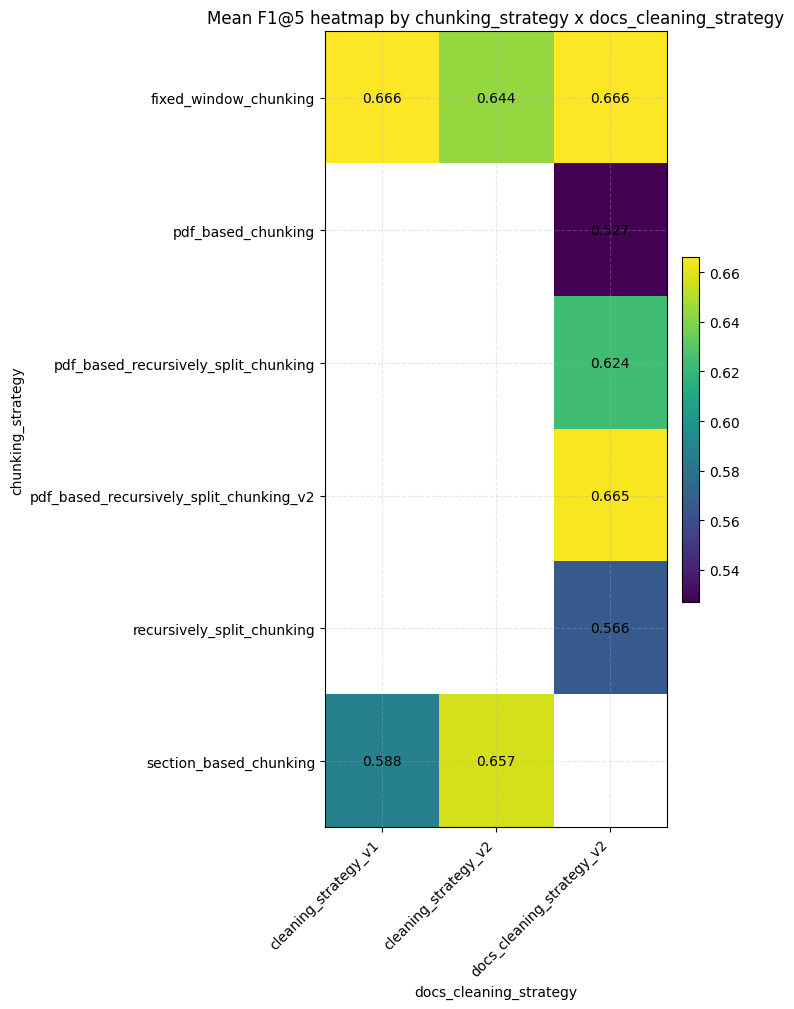

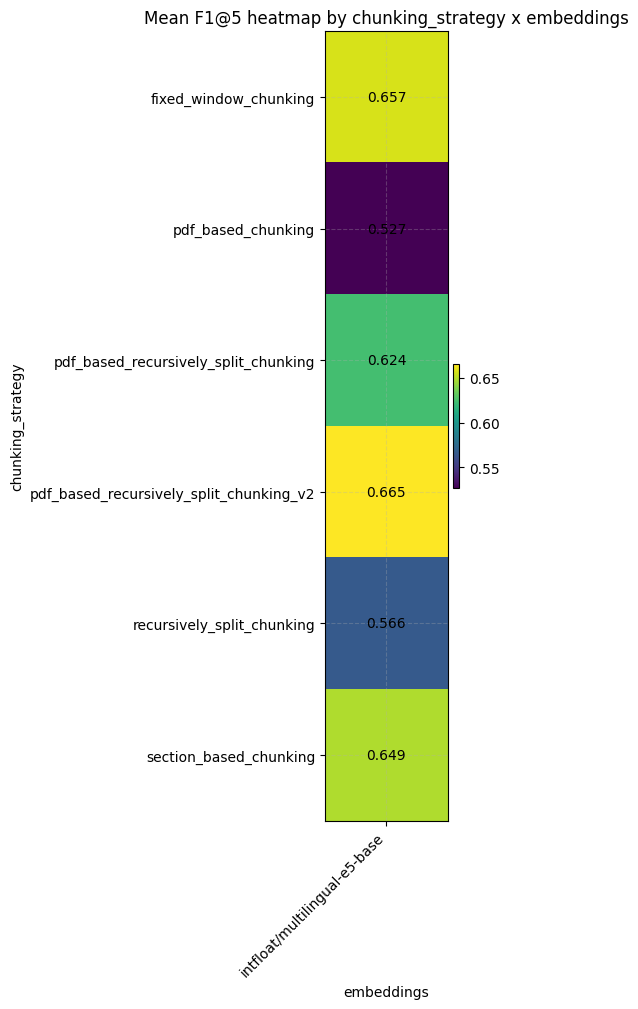

In [19]:
# 6) Heatmaps for interaction effects
two_way_heatmap(df, rows="embeddings", cols="reranker", metric="f1", k=5)
two_way_heatmap(df, rows="chunking_strategy", cols="docs_cleaning_strategy", metric="f1", k=5)
two_way_heatmap(df, rows="chunking_strategy", cols="embeddings", metric="f1", k=5)

In [20]:
def radar_top_configs(
    df: pd.DataFrame,
    top_n: int = 5,
    metric_sets: list[tuple[str, int]] = [("precision",3),("recall",3),("f1",3),("precision",5),("recall",5),("f1",5),("precision",10),("recall",10),("f1",10)],
    group_by: list[str] = ["embeddings","reranker","chunking_strategy","docs_cleaning_strategy"],
):
    """
    Radar chart comparing top_n configurations across multiple metrics (@3/@5/@10).
    Uses mean over duplicates within each config key.
    """
    # Pick top by Mean F1@5 as a reasonable default
    base = leaderboard(df, by=group_by, metric="f1", k=5, n=top_n, with_error=False)
    keys = base[group_by].astype(str).agg(" | ".join, axis=1).tolist()

    agg_cols = [metric_col(m, k) for m,k in metric_sets]
    g = df.groupby(list(group_by), dropna=False)[agg_cols].mean().reset_index()
    g["key"] = g[group_by].astype(str).agg(" | ".join, axis=1)
    M = g[g["key"].isin(keys)].set_index("key")[agg_cols]

    # Normalize per metric for fair polar comparison (min-max to [0,1])
    norm = (M - M.min()) / (M.max() - M.min()).replace(0, np.nan)

    # Radar
    labels = [f"{m.upper()}@{k}" for m,k in metric_sets]
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    angles = np.concatenate([angles, angles[:1]])

    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    for key, row in norm.iterrows():
        vals = row.values.astype(float)
        vals = np.concatenate([vals, vals[:1]])
        ax.plot(angles, vals, marker="o", label=key)
        ax.fill(angles, vals, alpha=0.05)
    ax.set_xticks(angles[:-1]); ax.set_xticklabels(labels)
    ax.set_yticklabels([])
    ax.set_ylim(0, 1)
    ax.legend(loc="upper left", bbox_to_anchor=(1.03, 1.05), frameon=False)
    ax.set_title("Top configs across metrics (normalized)")
    fig.tight_layout()
    plt.show()

/var/folders/0r/dktk9n0551j0gkccz4k6246h0000gn/T/ipykernel_8953/1709493473.py:40: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


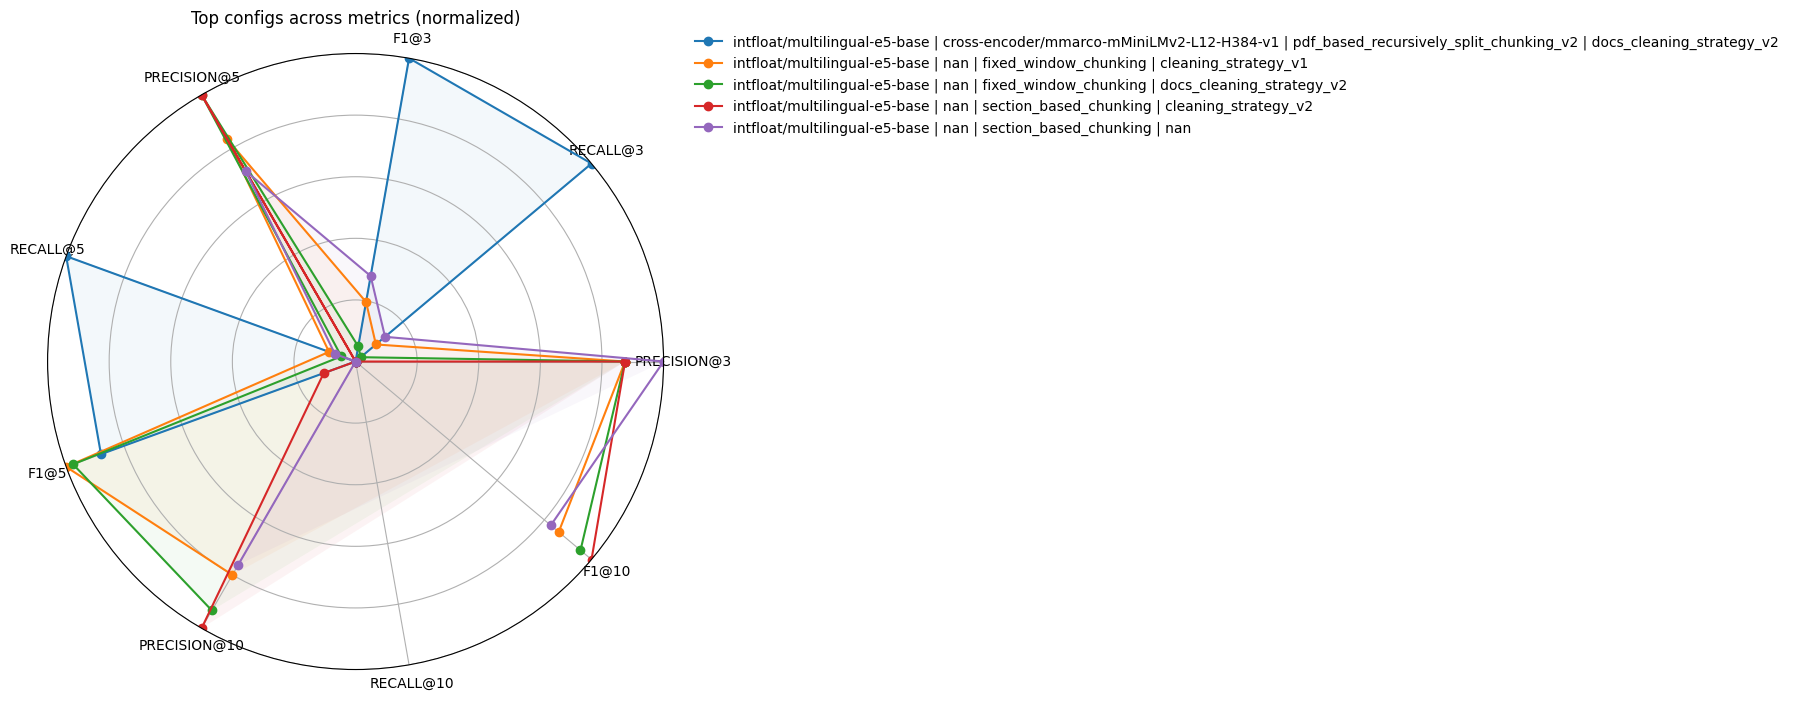

In [21]:
# 8) Radar: compare top-N configs across ALL metrics
radar_top_configs(df, top_n=5)

In [22]:
def time_series(
    df: pd.DataFrame, metric: str = "f1", k: int = 5, resample: str|None = None, rolling: int = 3
):
    """
    Plot metric@k over timestamp (optionally resampled or rolling-smoothed).
    """
    df = _safe_to_datetime(df)
    col = metric_col(metric, k)
    if "timestamp" not in df.columns or df["timestamp"].isna().all():
        raise ValueError("timestamp column missing or not parseable")

    s = df.sort_values("timestamp").set_index("timestamp")[col]
    if resample:
        s = s.resample(resample).mean()
    if rolling and rolling > 1:
        s = s.rolling(rolling, min_periods=1).mean()

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(s.index, s.values, marker="o")
    _finish(ax, f"{col} over time", "timestamp", col)
    fig.tight_layout()
    plt.show()

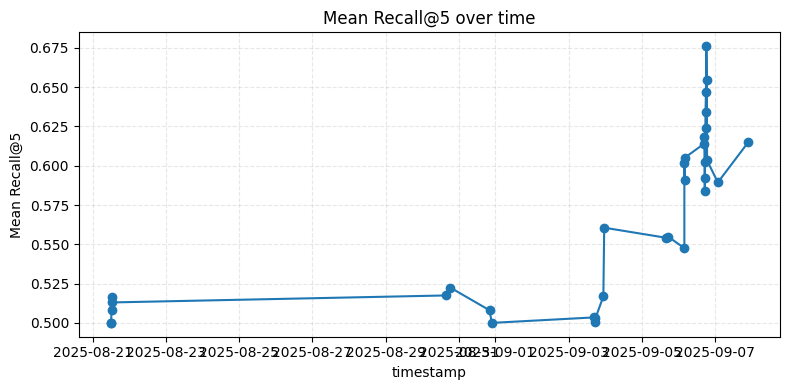

In [23]:
# 9) Time stability (if you have timestamp)
time_series(df, metric="recall", k=5, resample=None, rolling=5)

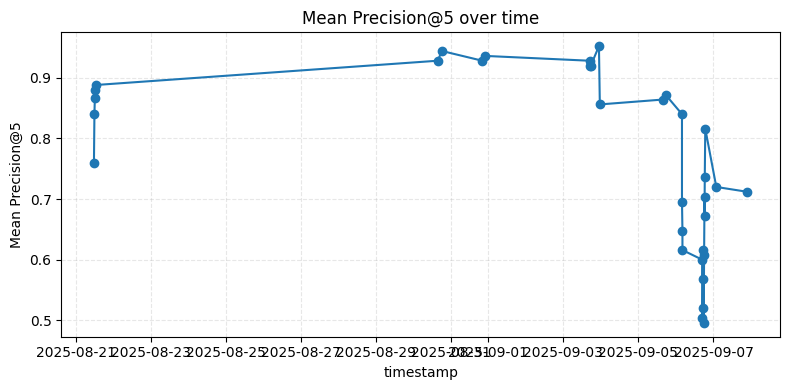

In [24]:
time_series(df, metric="precision", k=5, resample=None, rolling=5)

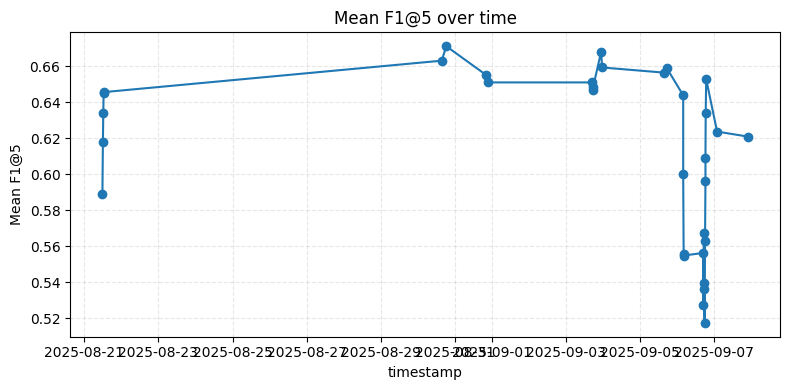

In [25]:
time_series(df, metric="f1", k=5, resample=None, rolling=5)

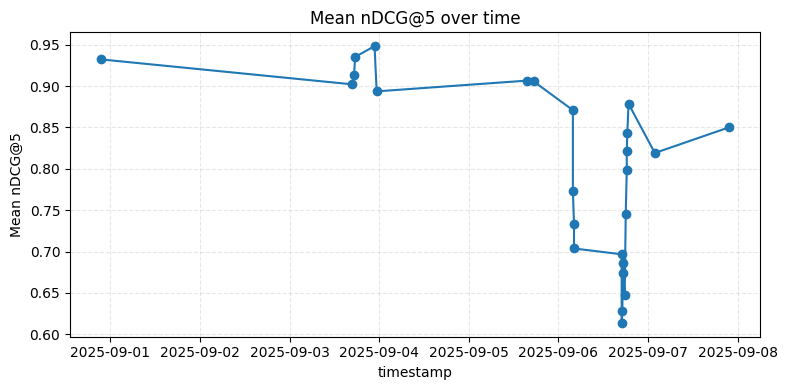

In [26]:
time_series(df, metric="ndcg", k=5, resample=None, rolling=5)

In [27]:
def filter_df(df: pd.DataFrame, **equals) -> pd.DataFrame:
    """
    Filter by exact matches, e.g. filter_df(df, embeddings="bge-base", reranker="rerank-v2").
    Ignores keys not present in df.
    """
    mask = pd.Series(True, index=df.index)
    for k, v in equals.items():
        if k in df.columns:
            mask &= (df[k] == v)
    return df[mask].copy()


# ----------------------
# A/B bootstrap (fast + assumption-light)
# ----------------------

def bootstrap_mean_diff(
    a: Union[pd.Series, np.ndarray],
    b: Union[pd.Series, np.ndarray],
    n_boot: int = 5000,
    random_state: int|None = 42,
) -> dict[str, float]:
    """
    Bootstrap the difference in means: mean(a) - mean(b).
    Returns dict with est, low, high, p (2-sided), and sample sizes.
    """
    rng = np.random.default_rng(random_state)
    a = np.asarray(a.dropna() if isinstance(a, pd.Series) else a, dtype=float)
    b = np.asarray(b.dropna() if isinstance(b, pd.Series) else b, dtype=float)
    if len(a) == 0 or len(b) == 0:
        raise ValueError("Empty samples for bootstrap")
    est = a.mean() - b.mean()
    boot = []
    for _ in range(n_boot):
        sa = rng.choice(a, size=len(a), replace=True)
        sb = rng.choice(b, size=len(b), replace=True)
        boot.append(sa.mean() - sb.mean())
    boot = np.array(boot)
    low, high = np.percentile(boot, [2.5, 97.5])
    # two-sided p-value for H0: diff = 0
    p = 2 * min((boot >= 0).mean(), (boot <= 0).mean())
    return {"est": est, "low": low, "high": high, "p": float(p), "n_a": len(a), "n_b": len(b)}

def ab_compare(
    df: pd.DataFrame,
    filter_A: dict[str, object],
    filter_B: dict[str, object],
    metric: str = "f1",
    k: int = 5,
) -> dict[str, float]:
    """
    Compare two slices A vs B on metric@k using bootstrap CI.
    Example:
        ab_compare(df, {"embeddings":"bge-base"}, {"embeddings":"e5-base"}, metric="f1", k=5)
    """
    col = metric_col(metric, k)
    da = filter_df(df, **filter_A)[col]
    db = filter_df(df, **filter_B)[col]
    out = bootstrap_mean_diff(da, db)
    out["metric"] = f"{metric.upper()}@{k}"
    out["A"] = str(filter_A)
    out["B"] = str(filter_B)
    return out

In [28]:
# 10) A/B delta with bootstrap CI
ab_compare(
    df,
    filter_A={"embeddings": "bge-base", "reranker": "none"},
    filter_B={"embeddings": "bge-large", "reranker": "cross-enc-v2"},
    metric="f1",
    k=5,
)

ValueError: Empty samples for bootstrap